In [19]:
import torch
from torch.distributions import MultivariateNormal, MixtureSameFamily, Categorical

In [882]:
means = torch.tensor([[-2, 2], [0,0], [2, 2]]).float()

m = MultivariateNormal(means, torch.stack([torch.eye(2)]*3))

In [883]:
mm = MixtureSameFamily(Categorical(torch.tensor([0.2]*3)), m)

In [884]:
samples = mm.sample(torch.tensor([10000]))

In [885]:
from matplotlib import pyplot as plt

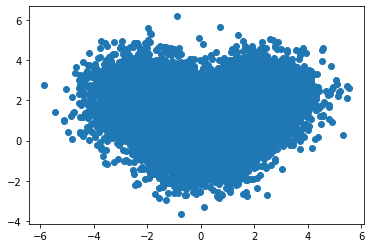

In [886]:
plt.scatter(samples[:, 0], samples[:, 1])

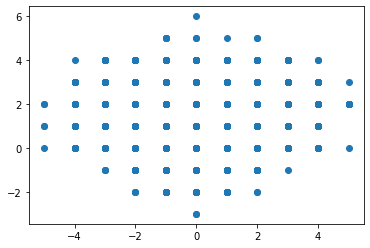

In [887]:
plt.scatter(samples.int()[:, 0], samples.int()[:, 1])

(array([[  0.,   0.,   0.,   1.,   4.,   4.,   2.,   0.,   0.,   0.],
        [  0.,   0.,   2.,   9.,  37.,  66.,  66.,  25.,   3.,   0.],
        [  0.,   1.,   9.,  39., 192., 341., 271.,  82.,  19.,   0.],
        [  2.,  15.,  76., 178., 363., 506., 393., 151.,  24.,   3.],
        [  5.,  60., 243., 426., 463., 393., 227.,  72.,  10.,   1.],
        [  6.,  49., 236., 492., 485., 336., 153.,  65.,   4.,   1.],
        [  1.,  31., 104., 231., 408., 534., 360., 126.,  17.,   1.],
        [  1.,   2.,  11.,  65., 217., 449., 328., 120.,  17.,   0.],
        [  0.,   0.,   0.,  16.,  51., 119., 112.,  33.,   5.,   0.],
        [  0.,   0.,   0.,   1.,   5.,   8.,  12.,   2.,   2.,   0.]]),
 array([-5.85380268, -4.7158061 , -3.57780952, -2.43981295, -1.30181637,
        -0.16381979,  0.97417679,  2.11217337,  3.25016994,  4.38816652,
         5.5261631 ]),
 array([-3.6446774 , -2.66175931, -1.67884121, -0.69592311,  0.28699498,
         1.26991308,  2.25283117,  3.23574927,  4.218667

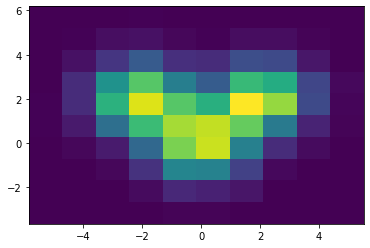

In [888]:
plt.hist2d(samples[:, 0].numpy(), samples[:, 1].numpy())

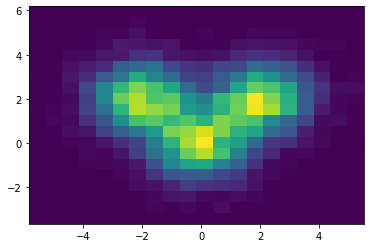

In [889]:
img, x_grid, y_grid, _ = plt.hist2d(samples[:, 0].numpy(), samples[:, 1].numpy(), bins = [20, 20])

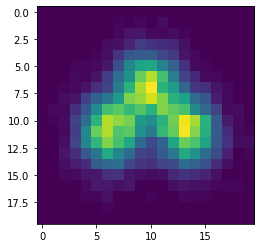

In [890]:
plt.imshow(img.transpose())

To implement the EM algorithm, we need the truncated normal distribution:

- Implementation of truncated multivariate distribution in R: tmvtnorm package
- This could be useful: https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.multivariate_normal.html


In [891]:
import rpy2
import numpy as np
from rpy2.robjects import numpy2ri
numpy2ri.activate()

In [892]:
from rpy2.robjects.packages import importr

In [893]:
import rpy2.robjects as robjects

In [894]:
tmv = importr("tmvtnorm")

In [895]:
strr = robjects.r('dim')

In [896]:
np2vec = robjects.r('as.vector')

In [897]:
xxx=robjects.r('list(a=5,b=matrix(c(7,8,27,99), nrow=1))')

In [898]:
xxx[0]

array([5.])

In [899]:
xxx[1]

array([[ 7.,  8., 27., 99.]])

In [900]:
np2vec

<rpy2.robjects.functions.SignatureTranslatedFunction object at 0x7efee5ca21c0> [RTYPES.CLOSXP]
R classes: ('function',)

In [901]:
np2vec(means[0].numpy().astype(np.float64)

SyntaxError: unexpected EOF while parsing (2403992266.py, line 1)

In [902]:
x = robjects.r.rnorm(100)

In [903]:
x.r_repr

AttributeError: 'numpy.ndarray' object has no attribute 'r_repr'

In [904]:
mtmvnorm = robjects.r('function(m, l) tmvtnorm::mtmvnorm(as.vector(m), lower=as.vector(l), doComputeVariance=FALSE)$tmean')

In [905]:
mtmvnorm(means[0].numpy(), l=np.array([0.,0.]))

array([0.37321553, 2.05524786])

In [906]:
from importlib import reload
import trunc_mvnorm
reload(trunc_mvnorm)

<module 'trunc_mvnorm' from '/home/derek/meta_repo/bliss/case_studies/galaxy_identifiability/trunc_mvnorm.py'>

In [907]:
tm = trunc_mvnorm.TruncMVNorm()

In [908]:
tm.mtmvnorm(means[0].numpy(), None, np.array([[0.,0.], [-1., -1.]]), np.array([[1.,1.], [0., 0.]]))

(array([[ 0.31582133,  0.61683095],
        [-0.61683095, -0.31582133]]),
 array([[[ 6.15207796e-02, -1.77635684e-15],
         [-1.77635684e-15,  7.27428861e-02]],
 
        [[ 7.27428861e-02, -1.11022302e-14],
         [-1.06581410e-14,  6.15207796e-02]]]))

In [909]:
tm.pmvnorm(means[0].numpy(), None, np.array([[0.,0.], [-1., -1.]]), np.array([[1.,1.], [0., 0.]]))

array([[0.0029084],
       [0.0029084]])

In [910]:
x_grid

array([-5.85380268, -5.28480439, -4.7158061 , -4.14680781, -3.57780952,
       -3.00881124, -2.43981295, -1.87081466, -1.30181637, -0.73281808,
       -0.16381979,  0.4051785 ,  0.97417679,  1.54317508,  2.11217337,
        2.68117166,  3.25016994,  3.81916823,  4.38816652,  4.95716481,
        5.5261631 ])

In [911]:
y_grid

array([-3.6446774 , -3.15321835, -2.66175931, -2.17030026, -1.67884121,
       -1.18738216, -0.69592311, -0.20446407,  0.28699498,  0.77845403,
        1.26991308,  1.76137213,  2.25283117,  2.74429022,  3.23574927,
        3.72720832,  4.21866736,  4.71012641,  5.20158546,  5.69304451,
        6.18450356])

In [912]:
from einops import rearrange, repeat, reduce

In [913]:
x_limits = repeat(np.stack([x_grid[:-1], x_grid[1:]], axis=1), "x p -> x y p", y=y_grid.shape[0]-1)

In [914]:
y_limits = repeat(np.stack([y_grid[:-1], y_grid[1:]], axis=1), "y p -> x y p", x = x_grid.shape[0]-1)

In [915]:
x_limits.shape

(20, 20, 2)

In [916]:
y_limits.shape

(20, 20, 2)

In [917]:
limits = np.concatenate([x_limits, y_limits], axis=2)

In [918]:
limits.shape

(20, 20, 4)

In [919]:
limits[0,0]

array([-5.85380268, -5.28480439, -3.6446774 , -3.15321835])

In [920]:
limits_long = rearrange(limits, "X Y L -> (X Y) L")

In [921]:
res = tm.mtmvnorm(means[0].numpy(), None, limits_long[:, [0,2]], limits_long[:, [1,3]])
res_mean = rearrange(res[0], "(X Y) A -> X Y A", X=10, Y=10)
res_var = rearrange(res[1], "(X Y) A B -> X Y A B", X=10, Y=10)

EinopsError:  Error while processing rearrange-reduction pattern "(X Y) A -> X Y A".
 Input tensor shape: (400, 2). Additional info: {'X': 10, 'Y': 10}.
 Shape mismatch, 400 != 100

In [922]:
res_mean.shape

(10, 10, 2)

In [923]:
limits[-1, -1]

array([4.95716481, 5.5261631 , 5.69304451, 6.18450356])

In [924]:
res_mean[-1, -1]

array([6.21822556, 6.58886895])

In [925]:
res_var[-1, -1]

array([[9.23220109e-03, 2.94246776e+01],
       [2.94246776e+01, 1.00000000e+00]])

In [926]:
## Basic EM algorithm
from sklearn.cluster import KMeans

samples_pixel = samples.int() + 0.5
km = KMeans(n_clusters=3)
km.fit(samples_pixel)
km.cluster_centers_

array([[ 0.50102171,  0.51532567],
       [-1.04844498,  2.2263756 ],
       [ 2.37632251,  2.09686246]])

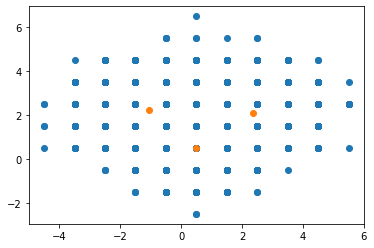

In [927]:
plt.scatter(samples_pixel[:, 0], samples_pixel[:, 1])
plt.scatter(km.cluster_centers_[:, 0], km.cluster_centers_[:, 1])

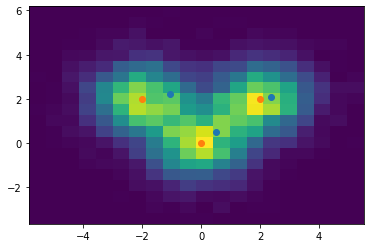

In [953]:
plt.hist2d(samples[:, 0].numpy(), samples[:, 1].numpy(), bins=[20,20])
plt.scatter(km.cluster_centers_[:, 0], km.cluster_centers_[:, 1])
plt.scatter(means[:, 0], means[:, 1])

In [929]:
from tqdm import tqdm

In [930]:
limits.shape

(20, 20, 4)

In [1029]:
def basic_em(grid, limits, mu_start, pi_start, n_iter):
    grid_long = rearrange(grid, "X Y -> (X Y)")
    limits_long = rearrange(limits, "X Y L -> (X Y) L")
    limits_lower_long = limits_long[:, [0,2]]
    limits_upper_long = limits_long[:, [1,3]]

    
    dim_X, dim_Y = grid.shape
    centered_vals_long = (limits_lower_long + limits_upper_long) / 2
    centered_vals = rearrange(centered_vals_long, "(X Y) L -> X Y L", X=dim_X, Y=dim_Y)
    mu = np.copy(mu_start)
    pi = np.copy(pi_start)
    for _ in tqdm(range(n_iter)):
        ## E-step
        ## Calculate log-probability of each cluster
        probs_list = []
        for j in range(mu.shape[0]):
            ## Get expectation in each pixel
            #res = tm.mtmvnorm(mus[j], None, limits_long[:, [0,2]], limits_long[:, [1,3]])
            #res_mean = rearrange(res[0], "(X Y) A -> X Y A", X=10, Y=10)
            #res_var = rearrange(res[1], "(X Y) A B -> X Y A B", X=10, Y=10)
            ## Calculate the log-probability
            probs_j = tm.pmvnorm(mu[j], None, limits_lower_long, limits_upper_long)
            probs_list.append(probs_j)
        probs_long = np.stack(probs_list)
        #return(probs_long)
        #print(probs_long)
        probs = rearrange(probs_long, "K (X Y) 1 -> K X Y", X=dim_X, Y=dim_Y)
        #return probs
        ## Multiply by the prior
        probs = rearrange(pi, "K -> K 1 1") * probs
        probs = probs / reduce(probs, "K X Y -> 1 X Y", "sum")

        ## M-step
        prob_global = reduce((probs * grid), "K X Y -> K", "sum")
        pi = prob_global / prob_global.sum()
        
        for j in range(mu.shape[0]):
            probs_j = probs[j]
            #print(probs_j.shape)
            W = rearrange(probs_j * grid, "X Y -> X Y 1")
            #eturn probs_j, W
            
            #res = tm.mtmvnorm(mu[j], None, limits_lower_long, limits_upper_long)
            #res_mean = rearrange(res[0], "(X Y) A -> X Y A", X=dim_X, Y=dim_Y)
            res_mean = centered_vals
            #return res_mean
            #return res[0]
            mu[j] = reduce(W * res_mean, "X Y A -> A", "sum")
            mu[j] = mu[j] / (W).sum()
            print(mu[j])
    return mu, pi, probs

In [1030]:
output = basic_em(img, limits, km.cluster_centers_, np.ones(3)/3, 20)

  5%|██▌                                                | 1/20 [00:00<00:08,  2.18it/s]

[0.19753611 0.12728586]
[-1.78316563  1.95486667]
[2.27334496 2.10474933]


 10%|█████                                              | 2/20 [00:00<00:08,  2.22it/s]

[0.15106274 0.07230668]
[-1.9296234   1.95448024]
[2.17957722 2.10946144]


 15%|███████▋                                           | 3/20 [00:01<00:07,  2.17it/s]

[0.10095803 0.04788975]
[-1.983594    1.97093242]
[2.11924936 2.0860207 ]


 20%|██████████▏                                        | 4/20 [00:01<00:07,  2.20it/s]

[0.05854133 0.03229431]
[-2.00878435  1.98664541]
[2.08477344 2.06322962]


 25%|████████████▊                                      | 5/20 [00:02<00:06,  2.18it/s]

[0.02646547 0.02146603]
[-2.02231419  1.99859645]
[2.06340767 2.04531946]


 30%|███████████████▎                                   | 6/20 [00:02<00:06,  2.21it/s]

[0.00338041 0.01376315]
[-2.03021983  2.0070005 ]
[2.04922896 2.03208614]


 35%|█████████████████▊                                 | 7/20 [00:03<00:06,  2.16it/s]

[-0.01285464  0.00819241]
[-2.03506667  2.01270452]
[2.03946335 2.02254517]


 40%|████████████████████▍                              | 8/20 [00:03<00:05,  2.13it/s]

[-0.02414517  0.00410817]
[-2.03810879  2.01650424]
[2.03261899 2.0157411 ]


 45%|██████████████████████▉                            | 9/20 [00:04<00:05,  1.99it/s]

[-0.03195359  0.00108234]
[-2.04003237  2.01900547]
[2.02778434 2.01091251]


 50%|█████████████████████████                         | 10/20 [00:04<00:04,  2.01it/s]

[-0.03733877 -0.00117581]
[-2.04124483  2.02063627]
[2.02435666 2.00749235]


 55%|███████████████████████████▌                      | 11/20 [00:05<00:04,  2.00it/s]

[-0.0410475 -0.0028692]
[-2.04200074  2.02168946]
[2.02192144 2.00507051]


 60%|██████████████████████████████                    | 12/20 [00:05<00:04,  1.98it/s]

[-0.04359993 -0.00414289]
[-2.04246348  2.0223623 ]
[2.02018861 2.00335455]


 65%|████████████████████████████████▌                 | 13/20 [00:06<00:03,  2.00it/s]

[-0.04535602 -0.00510266]
[-2.04273913  2.02278644]
[2.01895375 2.00213733]


 70%|███████████████████████████████████               | 14/20 [00:06<00:03,  1.86it/s]

[-0.04656412 -0.00582662]
[-2.04289673  2.02304925]
[2.01807236 2.00127261]


 75%|█████████████████████████████████████▌            | 15/20 [00:07<00:02,  1.96it/s]

[-0.04739526 -0.006373  ]
[-2.04298105  2.02320835]
[2.01744218 2.00065725]


 80%|████████████████████████████████████████          | 16/20 [00:07<00:02,  1.95it/s]

[-0.04796714 -0.00678545]
[-2.04302092  2.02330157]
[2.01699079 2.00021852]


 85%|██████████████████████████████████████████▌       | 17/20 [00:08<00:01,  2.00it/s]

[-0.04836069 -0.00709682]
[-2.04303469  2.02335352]
[2.01666684 1.99990511]


 90%|█████████████████████████████████████████████     | 18/20 [00:08<00:00,  2.03it/s]

[-0.0486316  -0.00733187]
[-2.04303389  2.02338013]
[2.01643388 1.99968076]


 95%|███████████████████████████████████████████████▌  | 19/20 [00:09<00:00,  1.97it/s]

[-0.04881812 -0.00750929]
[-2.04302561  2.02339159]
[2.01626602 1.99951982]


100%|██████████████████████████████████████████████████| 20/20 [00:09<00:00,  2.03it/s]

[-0.0489466  -0.00764318]
[-2.04301411  2.02339434]
[2.0161448  1.99940413]


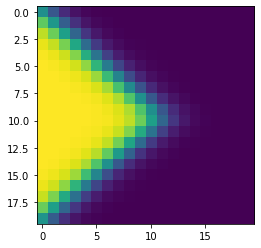

In [1036]:
plt.imshow(output[2][0])

In [1006]:
#output[1].max()

In [1037]:
output

(array([[-0.0489466 , -0.00764318],
        [-2.04301411,  2.02339434],
        [ 2.0161448 ,  1.99940413]]),
 array([0.33445409, 0.33032328, 0.33522263]),
 array([[[4.98391847e-01, 2.71276423e-01, 1.22475381e-01, ...,
          5.82841321e-08, 2.18360612e-08, 8.17497705e-09],
         [7.51197809e-01, 5.30783566e-01, 2.97809769e-01, ...,
          1.77110773e-07, 6.63542859e-08, 2.48416953e-08],
         [9.01587679e-01, 7.74390480e-01, 5.62725531e-01, ...,
          5.37406811e-07, 2.01338702e-07, 7.53771223e-08],
         ...,
         [9.14924096e-01, 8.02997204e-01, 6.07220051e-01, ...,
          7.67260168e-07, 2.90784639e-07, 1.10126468e-07],
         [7.73212699e-01, 5.63745629e-01, 3.28911137e-01, ...,
          2.43245401e-07, 9.21877693e-08, 3.49135092e-08],
         [5.19067687e-01, 2.90314686e-01, 1.34313317e-01, ...,
          7.70024425e-08, 2.91832143e-08, 1.10523162e-08]],
 
        [[5.01608153e-01, 7.28723577e-01, 8.77524619e-01, ...,
          9.99999941e-01, 9.9999

In [1038]:
np.ones(3)/3

array([0.33333333, 0.33333333, 0.33333333])

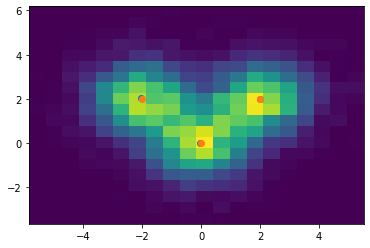

In [1039]:
plt.hist2d(samples[:, 0].numpy(), samples[:, 1].numpy(), bins=[20,20])
plt.scatter(output[0][:, 0], output[0][:, 1])
plt.scatter(means[:, 0], means[:, 1])

In [936]:
km.cluster_centers_

array([[ 0.50102171,  0.51532567],
       [-1.04844498,  2.2263756 ],
       [ 2.37632251,  2.09686246]])

- Almost spot on when "galaxies" are clearly separated (4, -4), (0,0), (4, 4)
- EM converges to center when closer together

- Works for 3